### Copyright (C) Infineon Technologies AG 2025
 
Use of this file is subject to the terms of use agreed between (i) you or the company in which ordinary course of 
business you are acting and (ii) Infineon Technologies AG or its licensees. If and as long as no such terms of use
are agreed, use of this file is subject to following:
 
This file is licensed under the terms of the Boost Software License. See the LICENSE file in the root of this repository
for complete details.

### Model Template

This is a template for adding a new model that is already trained and ready for inference. Please run this first (to make sure everything works on your machine) and then navigate through the TO DOs to add your model and data step by step. 

In [8]:
# TO DO: remove libs you don't need and add libs you need

import sys
import os

# Add the parent directory to the Python path so we can import from central_scripts
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import CentralScripts.helper_functions as cs

#### Adding a Model

The purpose of the model is to demonstrate compilation for AURIX&trade;. You are invited to replace this by your model.

In [9]:
from modelling_helper import get_model

# TO DO: add your model in modelling helper
origin = "tf"  # choose your origin, e.g., "tf" for TensorFlow, "torch" for PyTorch

# TO DO: choose your model_name
model_name = "new_model"

# TO DO: add your model
model = get_model(origin)

/home/wsluser/git/ai-model-zoo-productive/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Adding Input Data

You could use random input data or import your input data here and convert it into a numpy array.
We will run inference on it to generate the predictions.

In [10]:
import numpy as np

# TO DO: add an exemplary input as numpy array
input_target = np.random.rand(10).astype(np.float32)  # Example input for the model
output_target = cs.get_predictions(origin, model, input_target)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


#### Export and Save Model and Data

We now export model, input, and output data: 
- the model will be converted into ONNX
- input, and output will be stored as .pb.

In [11]:
# export model and data as ONNX and .pb
cs.save_all(model_name, input_target, output_target, model, origin)
cs.test_onnx_pb(model_name)

Directory already exists: out/new_model/test_new_model
Output matches expected output within tolerance.


#### Compiling the Model for AURIX&trade;

All the tools we need are included in a docker container. We fetch / start the Docker container next.

In [12]:
# Check if the docker container is running. If not, fetch and/ or start it.
cs.ensure_docker_container()

Docker container 'trusting_lewin' (from image 'docker-atv-sae-ai-public-registry.vih.infineon.com/tc_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


We now generate a C file from the ONNX and convert this into an elf file next. The elf file is executed using the open source hardware emulator qemu to estimate the execution. 

In [13]:
from CentralScripts.python_flask_client import CallTools

model_folder, onnx_model_file = cs.get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

Target folder out/new_model/test_new_model/TC3 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
Target folder out/new_model/test_new_model/TC4 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


#### Analysis of Execution Timing

- For each node in the neural network the number of clock cycles is extracted from the log file and plotted.
- You can inspect which node is a computational bottleneck and adjust your network if wanted.

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


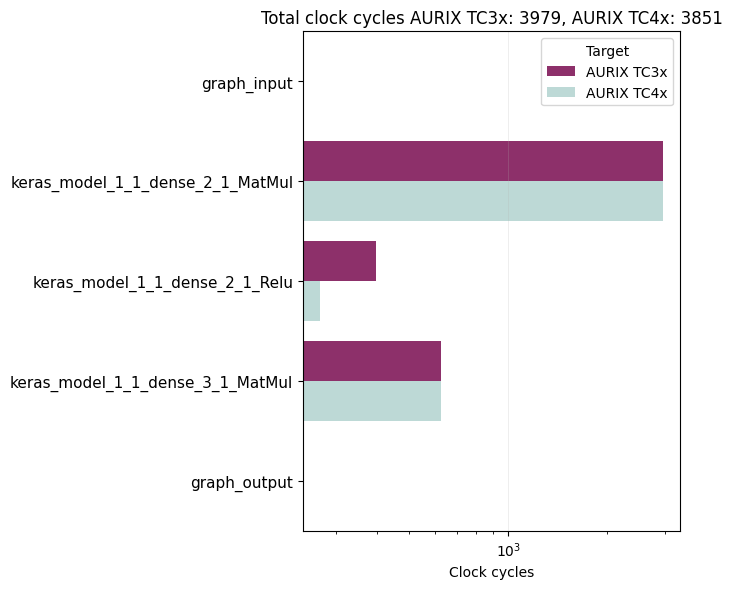

In [14]:
cs.plot_execution_timing(model_name)

#### Congrats on Compiling your Model. 
If you got here without any error, it looks like you made it.